# SIMD-based Conv2D Object Detection

In this notebook, we evaluate a custom C++ Conv2D engine (Baseline / SSE / AVX)

on a simple object detection task.

The pipeline includes: 

1. Synthetic dataset generation
2. Optional Gaussian noise injection
3. Edge-based object detection using Sobel (sobelx, sobely) filters
4. Bounding box extraction
5. IoU-based evaluation
6. Performance benchmarking across engines 

In [44]:
import os
import cv2
import json
import time
import shutil
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt

## Running the C++ Conv2D Engine 

The function below calls the compiled C++ program using CLI arguments.

It supports different engines: 

- baseline
- sse
- avx

The output image is read back into Python for further processing.

In [45]:
def run_conv2d(
    engine, 
    kernel_type, 
    kernel_size,
    input_path, 
    output_path,
    mode="functional"): 
    
    kernel_size_str = str(kernel_size)
    
    cmd = [
        "./02-run.sh",
        "--mode", mode,
        "--engine", engine,
        "--ktype", kernel_type,
        "--ksize", kernel_size_str,
        "--input", input_path,
        "--output", output_path,
        "--color", "rgb"
    ]
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print("Error running C++ program:")
        print(result.stderr)
        return None 
    
    return cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)

## Edge-Based Object Detection Pipeline 

The detection pipeline consists of: 

1. Gaussian blur (noise reduction)
2. Sobel X and Sobel Y filtering 
3. Gradient magnitude computation 
4. Canny edge detection 
5. Morphological dilation 
6. Connected component analysis 
7. Selecting the largest bounding box

All convolutions are performed using the selected SIMD engine.

In [46]:
def detect_rectangle(engine, input_image, mode="functional"):
        
    tmp_dir = "tmp"
    os.makedirs(tmp_dir, exist_ok=True)
    
    blur_img = run_conv2d(engine, "gaussian_blur", 7, input_image, tmp_dir + "/blur.png")

    gx_img = run_conv2d(engine, "sobel_x", 3, tmp_dir + "/blur.png", tmp_dir + "/gx.png")
    gy_img = run_conv2d(engine, "sobel_y", 3, tmp_dir + "/blur.png", tmp_dir + "/gy.png")
 
    gradient = np.sqrt(gx_img.astype(float) ** 2 + gy_img.astype(float) ** 2)
    max_val = gradient.max()
    if max_val > 0:
        gradient = (gradient / max_val) * 255
        
    gradient = gradient.astype(np.uint8)

    shutil.rmtree(tmp_dir)

    # Edge detection
    binary = cv2.Canny(gradient, 50, 150)

    kernel = np.ones((3,3), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=2)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    best_box = None
    best_area = 0

    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        if area > best_area:
            best_area = area
            best_box = (x, y, w, h)

    return best_box



## Synthetic Dataset Generation 

We generate images containing:

- A simple rectangle or circle 
- Random size 
- Random position 
- Random color 

Ground truth bounding boxes are saved in a JSON file.

In [47]:
def generate_dataset(output_dir="dataset", num_images=300):
    os.makedirs(output_dir, exist_ok=True)

    ground_truths = {}

    IMG_SIZE = 256

    for i in range(num_images):
        # White background
        img = np.ones((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8) * 255

        shape_type = random.choice(["rectangle", "circle"])

        # Random color (avoid white)
        color = (
            random.randint(0, 200),
            random.randint(0, 200),
            random.randint(0, 200)
        )

        if shape_type == "rectangle":
            w = random.randint(40, 120)
            h = random.randint(40, 120)
            x = random.randint(0, IMG_SIZE - w - 1)
            y = random.randint(0, IMG_SIZE - h - 1)

            cv2.rectangle(img, (x, y), (x+w, y+h), color, -1)

            gt_box = (x, y, w, h)

        elif shape_type == "circle":
            r = random.randint(20, 60)
            cx = random.randint(r, IMG_SIZE - r - 1)
            cy = random.randint(r, IMG_SIZE - r - 1)

            cv2.circle(img, (cx, cy), r, color, -1)

            x = cx - r
            y = cy - r
            w = 2 * r
            h = 2 * r

            gt_box = (x, y, w, h)

        filename = f"img_{i:04d}.png"
        cv2.imwrite(os.path.join(output_dir, filename), img)

        ground_truths[filename] = {
            "shape": shape_type,
            "bbox": gt_box
        }

    with open(os.path.join(output_dir, "ground_truth.json"), "w") as f:
        json.dump(ground_truths, f, indent=4)

    return ground_truths


## Gaussian Noise Injection 

To evaluate robustness,Gaussian noise is added to the dataset.

Noise parameters:

- Mean = 0
- Standard deviation = configurable 

In [48]:
def add_gaussian_noise_to_dataset(input_dir, output_dir, mean=0, std=15):

    os.makedirs(output_dir, exist_ok=True)
    
    shutil.copyfile(src=input_dir + "/ground_truth.json", dst=output_dir + "/ground_truth.json")

    for filename in os.listdir(input_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            # Generate noise
            noise = np.random.normal(mean, std, img.shape)
            noisy = img.astype(np.float32) + noise

            # Clip to valid range
            noisy = np.clip(noisy, 0, 255).astype(np.uint8)

            cv2.imwrite(output_path, noisy)

In [49]:
# Here we generate a random synthetic dataset
# Then add gaussian noise to it and save the output images in another dataset

clean_dataset_dir = "dataset_clean"
noisy_dataset_dir = "dataset_noisy"

n_images = 100

gt = generate_dataset(clean_dataset_dir, n_images)

add_gaussian_noise_to_dataset(
    clean_dataset_dir,
    noisy_dataset_dir,
    std=15
)

## Evaluation Metrics 

We evaluate detection quality using: 

- Accuracy 
- Precision 
- Recall 
- Mean Intersection over Union (IoU)

IoU threshold for true positive classification = 0.75

In [50]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter_area = inter_w * inter_h

    areaA = boxA[2] * boxA[3]
    areaB = boxB[2] * boxB[3]

    union = areaA + areaB - inter_area

    if union == 0:
        return 0

    return inter_area / union


In [51]:
def compute_metrics(dataset, engine, threshold=0.75):

    TP = 0
    FP = 0
    FN = 0
    ious = []

    with open(os.path.join(dataset, "ground_truth.json")) as f:
        ground_truths = json.load(f)
        
    start_time = time.perf_counter()

    for filename, data in ground_truths.items():

        path = os.path.join(dataset, filename)
        gt_box = tuple(data["bbox"]) 

        pred_box = detect_rectangle(engine, path)

        if pred_box is None:
            FN += 1
            continue

        iou = compute_iou(gt_box, pred_box)
        ious.append(iou)

        if iou >= threshold:
            TP += 1
        else:
            FP += 1

    elapsed = time.perf_counter() - start_time
    
    total = len(ground_truths)

    accuracy  = TP / total if total > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    mean_iou  = np.mean(ious) if ious else 0

    return accuracy, precision, recall, mean_iou, elapsed


### Single Engine Evaluation 

In [52]:
engine  = "avx"
dataset = noisy_dataset_dir

accuracy, precision, recall, mean_iou, _ = compute_metrics(dataset, engine)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Mean IoU:", mean_iou)


Accuracy: 0.79
Precision: 0.79
Recall: 1.0
Mean IoU: 0.7822117348635337


## Detection Visualization

Green box  → Ground Truth  
Red box    → Prediction  

This helps visually inspect detection quality.

In [53]:
def visualize_detection(
    image_path, 
    gt_box=None, 
    pred_box=None, 
    save_path="debug_detection.png"):

    # Load original image 
    img = cv2.imread(image_path)
    vis = img.copy()

    # Draw GT box
    if gt_box is not None:
        x, y, w, h = gt_box
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(vis, "GT", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Draw predicted box
    if pred_box is not None:
        x, y, w, h = pred_box
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(vis, "PRED", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    cv2.imwrite(save_path, vis)

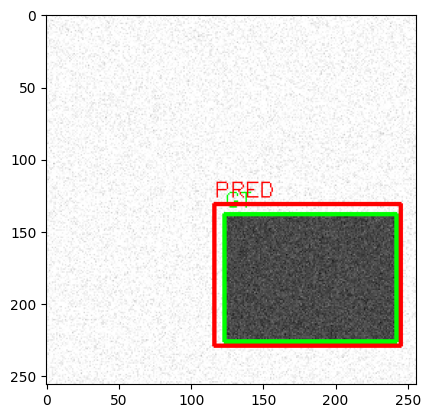

In [61]:
# Now we visualize one sample using the function above

engine  = "avx"
dataset = noisy_dataset_dir

with open(dataset + "/ground_truth.json") as f:
    ground_truths = json.load(f)
    
filename, data = next(iter(ground_truths.items()))

image_path = os.path.join(dataset, filename)

gt_box = tuple(data["bbox"])
pred_box = detect_rectangle(engine, image_path)

output_path = "visualization_sample.png"

visualize_detection(
    image_path,
    gt_box=gt_box,
    pred_box=pred_box,
    save_path=output_path
)

visualization_sample_img = plt.imread(output_path)

plt.imshow(visualization_sample_img)

os.remove(output_path)

### Visualization for n samples

This function generates the visualization detection image for n samples 

from given dataset and save the outputs in output directory

In [55]:
def visualize_detection_n(
    engine,
    dataset,
    output_dir="detection",
    n=10):
    
    with open(dataset + "/ground_truth.json") as f:
        ground_truths = json.load(f)
    
    os.makedirs(output_dir, exist_ok=True)

    for _, (filename, data) in zip(range(n), ground_truths.items()):
        
        image_path = os.path.join(dataset, filename)

        gt_box = tuple(data["bbox"])
        pred_box = detect_rectangle(engine, image_path)
        
        output_path = output_dir + "/" + filename 
        
        visualize_detection(
            image_path,
            gt_box=gt_box,
            pred_box=pred_box,
            save_path=output_path
        )
        

In [56]:
engine    = "avx"
dataset   = noisy_dataset_dir
n_samples = 10 

visualize_detection_n(engine, dataset, n=n_samples)

## Engine Benchmark Comparison 

We compare:

- Baseline implementation 
- SSE implementation 
- AVX implementation 

Metrics: 

- Runtime
- Accuracy 
- Precision
- Recall
- Mean IoU

Since all engines implement the same convolution

algorithm with identical kernels and parameters, we expect: 

- Similar Accuracy 
- Similar Precision and Recall
- Similar Mean IoU

In [57]:
def benchmark_all_engines(dataset):
    engines = ["baseline", "sse", "avx"]
    results = {}

    for engine in engines:
        acc, prec, rec, miou, t = compute_metrics(dataset, engine)

        results[engine.upper()] = {
            "time": t,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "mean_iou": miou
        }

    return results

In [58]:
def print_benchmark_results(results):
    for engine, metrics in results.items():
        print(f"\n=== {engine.upper()} ===")
        print(f"time      : {metrics['time']:.4f}s")
        print(f"accuracy  : {metrics['accuracy']:.3f}")
        print(f"precision : {metrics['precision']:.3f}")
        print(f"recall    : {metrics['recall']:.3f}")
        print(f"mean IoU  : {metrics['mean_iou']:.3f}")

In [59]:
dataset = noisy_dataset_dir
results = benchmark_all_engines(dataset)
print_benchmark_results(results)


=== BASELINE ===
time      : 20.4720s
accuracy  : 0.790
precision : 0.790
recall    : 1.000
mean IoU  : 0.782

=== SSE ===
time      : 20.3476s
accuracy  : 0.790
precision : 0.790
recall    : 1.000
mean IoU  : 0.782

=== AVX ===
time      : 20.2218s
accuracy  : 0.790
precision : 0.790
recall    : 1.000
mean IoU  : 0.782


In the previous notebook, we reached a ~5x speedup over baseline: 

$$
\frac{T_{baseline}}{T_{optimized}} \approx 5
$$

However, in the full detection pipeline we observe: 

$$
\frac{T_{baseline}}{T_{SSE}} \approx \frac{T_{baseline}}{T_{AVX}} \approx 1.01
$$

Almost no improvement.

To understand this, we apply **Amdahl's Law**.

### Amdahl's Law

If: 

- P = fraction of execution time that can be accelerated 
- S = speedup of that part 
- $T_{total}$ total execution time

Then the overall speedup is: 

$$
S_{total} = \frac{1}{(1 - P) + \frac{P}{S}}
$$

Let's assume: 

$S=5$

In full detection pipeline, we observed: 

$S_{total} \approx 1.01$ 

We solve for P: 

$P \approx 0.0124$

This means: 

Only about 1.2% of total execution time belongs to Conv2D computation.

The remaining 98.8% is spent in: 

- subprocess creation 
- disk I/O 
- OpenCV Canny 
- morphological operations
- connected components

If the benchmarking is restricted to the Conv2D operation alone, the SIMD implementations exhibit the same ~5× speedup observed in the micro-benchmark. However, in an end-to-end object detection pipeline, convolution represents only a small fraction of the total execution time. Consequently, accelerating the convolution kernel has a negligible impact on overall system performance.
